In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib
import importance_sample_lib as imp_lib
import common_utils 

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5, num_images=50, 
                        brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

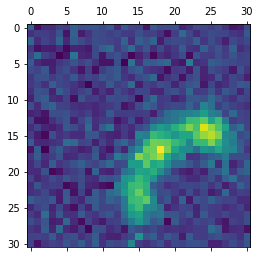

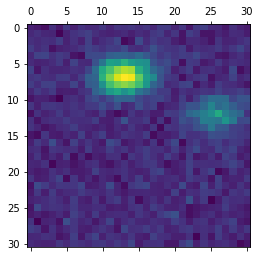

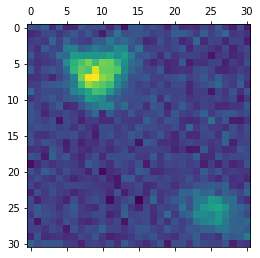

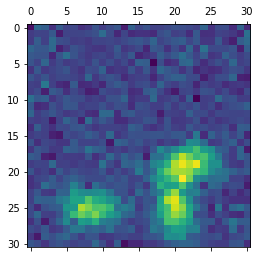

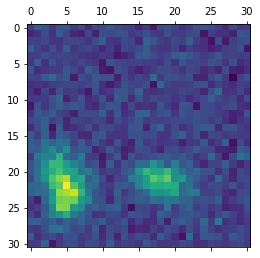

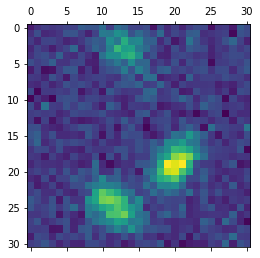

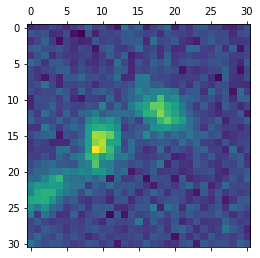

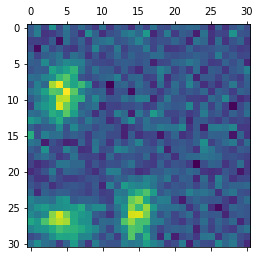

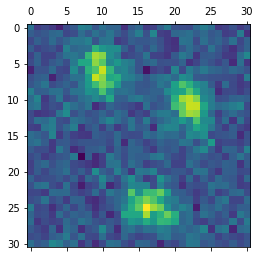

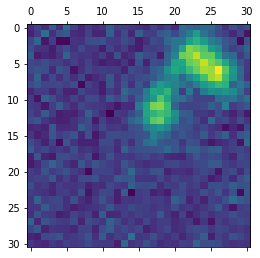

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
imp_weights = imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset=4, prob_off=0)

(array([392.,  32.,  25.,  24.,  14.,  11.,  13.,   7.,   8.,   4.]),
 array([0.        , 0.00155166, 0.00310332, 0.00465498, 0.00620664,
        0.0077583 , 0.00930996, 0.01086162, 0.01241328, 0.01396494,
        0.0155166 ]),
 <a list of 10 Patch objects>)

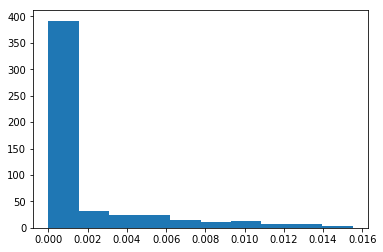

In [8]:
plt.hist(imp_weights[0, :])

# The VAE

In [9]:
one_galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [10]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

one_galaxy_vae.eval(); 

In [11]:
galaxy_vae = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=one_galaxy_vae)

In [12]:
pixel_probs = galaxy_vae.get_pixel_probs(images_batch1, backgrounds_batch1)

In [13]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [14]:
recon_mean, recon_var, is_on, kl_z = galaxy_vae.sample_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            image_so_far = backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [15]:
map_pixel_loc

tensor([ 337,  103,   76,  409,  440,  363,  306,  118,  181,  177])

In [16]:
is_on

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

(array([  1.,   0.,   0.,   0.,  54., 390.,  51.,  23.,   8.,   3.]),
 array([1.08262749e-16, 3.38033703e-04, 6.76067406e-04, 1.01410111e-03,
        1.35213481e-03, 1.69016852e-03, 2.02820222e-03, 2.36623592e-03,
        2.70426963e-03, 3.04230333e-03, 3.38033703e-03]),
 <a list of 10 Patch objects>)

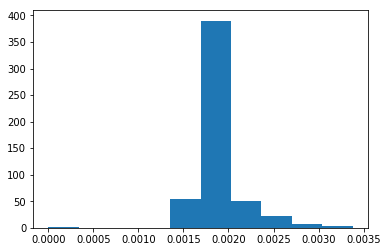

In [17]:
plt.hist(pixel_probs[0, :].detach())

In [18]:
recon_mean.sum()

tensor(662.5486)

In [19]:
recon_var.sum()

tensor(3980.5188)

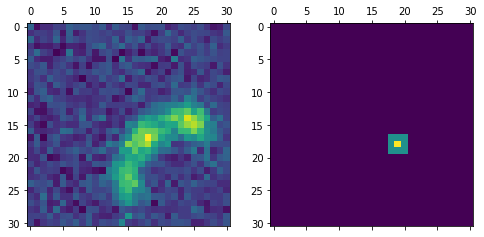

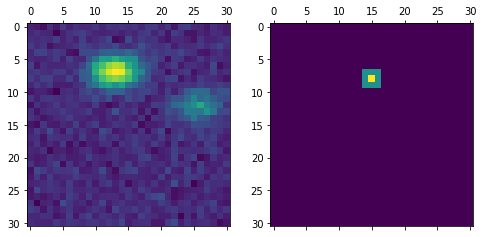

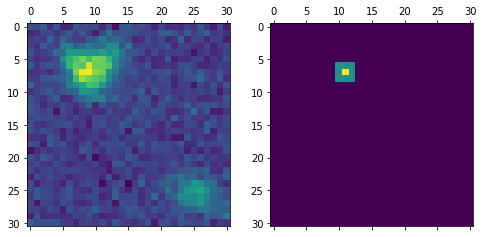

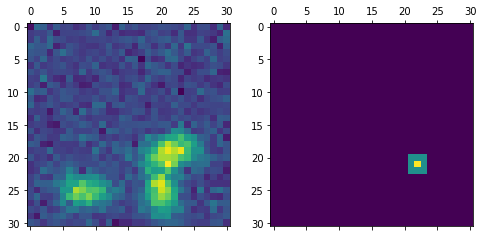

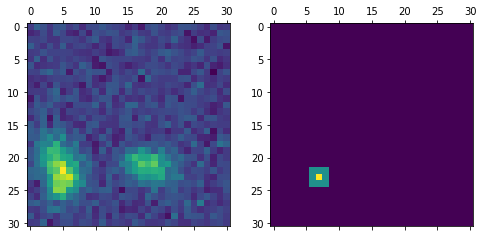

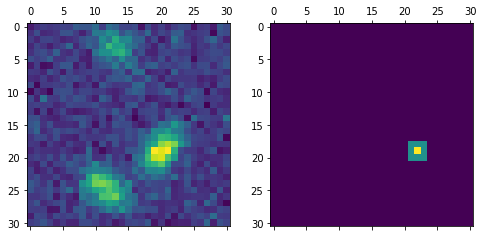

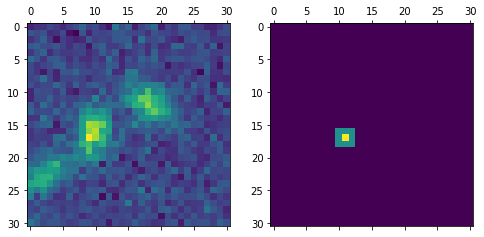

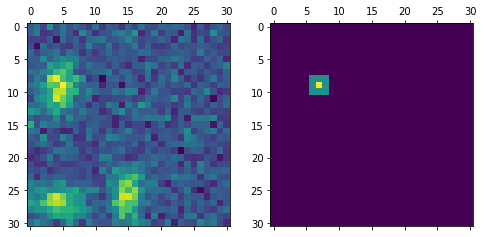

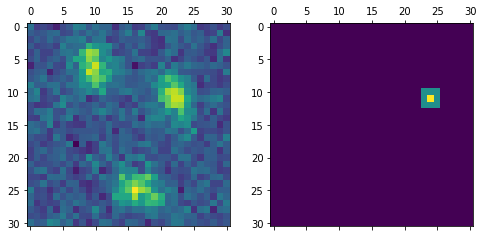

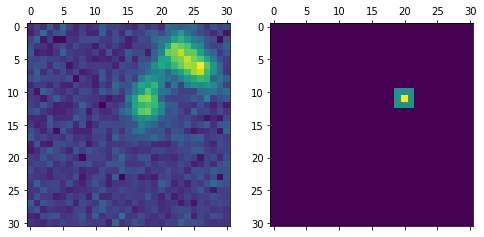

In [20]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


# Experimenting with new importance sampling functions

In [22]:
# function to normalize image
attn_offset = galaxy_vae.attn_offset
# normalized_image = imp_lib.crop_and_normalize_image(images_batch1, attn_offset)

In [23]:
# normalized_image.sum(dim = 1).sum(dim = 1) - 1

In [25]:
# append probability of being off
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1, attn_offset, prob_off)

In [26]:
np.max(np.abs(importance_weights.numpy().sum(1) - 1.0))

4.172325e-07

In [27]:
print(np.abs(importance_weights.numpy().sum(1) - 1.0))

[3.5762787e-07 1.7881393e-07 0.0000000e+00 2.3841858e-07 1.1920929e-07
 3.5762787e-07 0.0000000e+00 1.7881393e-07 5.9604645e-08 4.1723251e-07]


In [28]:
assert np.max(np.abs(importance_weights[:, -1].numpy() - prob_off.numpy().squeeze())) < 1e-16
assert np.max(np.abs(importance_weights.numpy().sum(1) - 1.0)) < 1e-6

In [29]:
# visually check importance weights: 

In [30]:
prob_off = torch.zeros((images_batch1.shape[0], 1)) # pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset, prob_off)

In [31]:
which_n = 1
image_sampled = torch.zeros((side_len, side_len))
for i in range(10000): 
    z_sample = common_utils.sample_class_weights(importance_weights)
    pixel_2d = galaxy_vae.one_galaxy_vae.pixel_1d_to_2d(z_sample)
    image_sampled[pixel_2d[which_n, 0], pixel_2d[which_n, 1]] += 1

(array([447.,  31.,  18.,   6.,   9.,   4.,   4.,   4.,   4.,   3.]),
 array([0.        , 0.00282321, 0.00564643, 0.00846964, 0.01129285,
        0.01411607, 0.01693928, 0.01976249, 0.02258571, 0.02540892,
        0.02823213]),
 <a list of 10 Patch objects>)

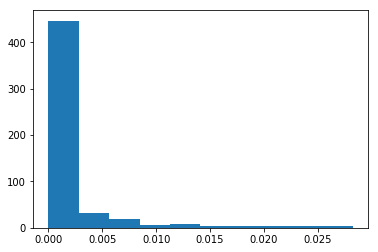

In [32]:
plt.hist(importance_weights[which_n, :])

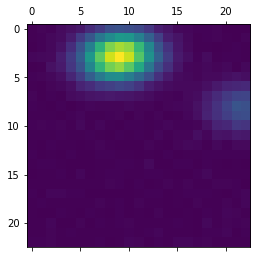

In [33]:
imp_weights_grid = importance_weights[:, 0:-1].view(images_batch1.shape[0], 23, 23)
plt.matshow(imp_weights_grid.detach()[which_n, :, :])

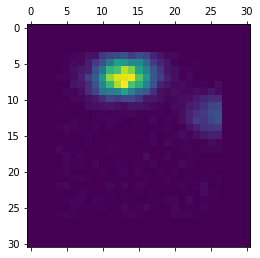

In [34]:
plt.matshow(image_sampled)

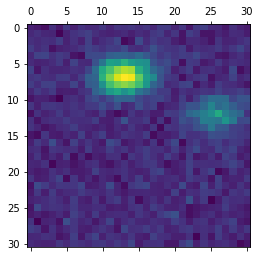

In [35]:
plt.matshow(images_batch1[which_n, 0, :, :])

In [36]:
# check optimizer goes through

In [37]:
optimizer = optim.Adam(galaxy_vae.parameters(), lr=0.01, weight_decay=1e-6)
optimizer.zero_grad()

In [42]:
pm_loss, neg_elbo, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

tensor([ 0.1918,  0.1407,  0.6729,  0.2268,  0.1797,  0.3478,  0.8587,
         2.4680,  0.3620,  0.3357])
tensor([ 0.0417,  0.0594,  0.0676,  0.0425,  0.1784,  0.2549,  0.3127,
         0.7357,  0.1099,  0.1493])
torch.Size([10])
torch.Size([10])
torch.Size([10])


In [43]:
# check params
all_params = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params = torch.cat([params, all_params])

In [44]:
pm_loss

tensor(1.00000e+06 *
       -2.0484)

In [45]:
pm_loss.backward()

In [46]:
optimizer.step()

In [48]:
_, neg_elbo2, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

tensor([ 0.4240,  0.3082,  0.1432,  0.0999,  0.2894,  1.2969,  0.1501,
         1.9282,  3.4704,  0.1338])
tensor([  0.1565,   0.0259,   0.0131,   0.9281,   0.0955,   0.2401,
          0.0417,  25.1554,   0.7003,   0.0717])
torch.Size([10])
torch.Size([10])
torch.Size([10])


In [49]:
neg_elbo2

tensor(1.00000e+05 *
       1.3105)

In [50]:
# check params
all_params2 = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params2 = torch.cat([params, all_params2])

In [51]:
torch.max(all_params2 - all_params)

tensor(1.00000e-02 *
       1.0000)

(array([1043184.,    4703.,    2140.,    1662.,  132682.,  148135.,
           1848.,    1926.,    4020., 1058221.]),
 array([-0.01000001, -0.008     , -0.006     , -0.004     , -0.002     ,
         0.        ,  0.002     ,  0.004     ,  0.006     ,  0.008     ,
         0.01000001]),
 <a list of 10 Patch objects>)

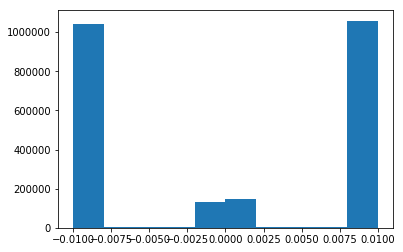

In [52]:
plt.hist((all_params2 - all_params).detach())

In [53]:
# Check train module

In [54]:
# train_module(vae, train_loader, test_loader, epochs,
#                         use_baseline = True,
#                         use_importance_sample = True,
#                         lr = 1e-4, weight_decay = 1e-6,
#                         save_every = 10,
#                         filename = './galaxy_vae_params',
#                         seed = 245345)

In [ ]:
imp_lib.train_module(galaxy_vae, train_loader, test_loader, 
                        epochs = 12, save_every = 2, 
                        use_baseline = True, 
                        use_importance_sample = True, 
                        max_detections = 2, 
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

tensor([ 0.1493,  0.7049,  0.0847,  0.1098,  0.1595,  0.2190,  0.1553,
         2.3381,  0.2460,  0.5626])
tensor([ 0.0423,  0.0540,  0.0071,  0.0774,  0.0198,  0.0466,  0.0604,
         3.8248,  0.0477,  0.0873])
torch.Size([10])
torch.Size([10])
torch.Size([10])
tensor([ 0.2009,  0.1695,  1.8080,  0.2387,  0.1279,  0.4493,  0.1097,
         2.8927,  0.1629,  1.0801])
tensor([ 0.0276,  0.4004,  0.1261,  0.1108,  0.1581,  2.0201,  0.0121,
         0.5277,  0.4954,  0.3818])
torch.Size([10])
torch.Size([10])
torch.Size([10])
tensor([ 0.1388,  0.0628,  0.0746,  0.2173,  0.1952,  0.1861,  0.6309,
         0.0865,  1.4897,  0.6090])
tensor([ 0.0398,  0.0234,  0.0045,  0.1199,  0.4691,  0.0332,  0.2023,
         0.0158,  0.5481,  0.8604])
torch.Size([10])
torch.Size([10])
torch.Size([10])
tensor([ 0.1679,  0.1617,  0.0746,  0.1762,  0.5234,  0.1995,  3.2753,
         0.1235,  0.1474,  4.9219])
tensor([ 0.0794,  0.4628,  0.0447,  0.0283,  0.3503,  0.1150,  0.3367,
         0.7900,  0.0219,  

In [ ]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [ ]:
galaxy_vae_reload

In [ ]:
np.load('./test_test_losses_array.npy')